In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=4000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
        
        
import os
import random
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model, load_model
from keras.layers import BatchNormalization, Dropout, LeakyReLU, Dense, Flatten, Activation, ReLU, UpSampling2D,PReLU,UpSampling3D
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv3D
from keras.layers.pooling import MaxPooling2D, MaxPooling3D, GlobalMaxPooling2D, GlobalAveragePooling2D,GlobalAveragePooling3D
from keras.layers.merge import concatenate, add, multiply, average
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
import matplotlib.pyplot as plt
import time
from IPython import display
from keras.activations import sigmoid
import glob
from tifffile import imwrite

1 Physical GPUs, 1 Logical GPUs


In [71]:
def stack_generator(GT_dr,low_dr, fr_start,fr_end):
    path_gt = GT_dr+'/*.tif'
    path_low = low_dr+'/*.tif'
    image_gt = imread(sorted(glob.glob(path_gt))).astype(np.float32)
    image_low = imread(sorted(glob.glob(path_low))).astype(np.float32)
    image_gt = np.moveaxis(image_gt,1,2)
    image_low = np.moveaxis(image_low,1,2)

    

    if len(image_gt.shape)==4:
        image_gt = np.reshape(image_gt,(image_gt.shape[0],image_gt.shape[1],1,image_gt.shape[2],image_gt.shape[3]))
        image_low = np.reshape(image_low,(image_low.shape[0],image_low.shape[1],1,image_low.shape[2],image_low.shape[3]))

    print(image_gt.shape)
#     for i in range(len(image_gt)):
#         for j in range(image_gt.shape[2]):
#             image_gt[i,:,j,:,:] = image_gt[i,:,j,:,:]/image_gt[i,:,j,:,:].max()
#             image_low[i,:,j,:,:] = image_low[i,:,j,:,:]/image_low[i,:,j,:,:].max()

    for j in range(image_gt.shape[2]):
        image_gt[:,:,j,:,:] = image_gt[:,:,j,:,:]/image_gt[:,:,j,:,:].max()
        image_low[:,:,j,:,:] = image_low[:,:,j,:,:]/image_low[:,:,j,:,:].max()

# #     for i in range(len(image_gt)):
#         for j in range(image_gt.shape[1]):
#             image_gt[i,j,:,:,:] = image_gt[i,j,:,:,:]/image_gt[i,j,:,:,:].max()
#             image_low[i,j,:,:,:] = image_low[i,j,:,:,:]/image_low[i,j,:,:,:].max()
    crop_gt = image_gt[:,fr_start:fr_end,:,:,:]
    crop_low = image_low[:,fr_start:fr_end,:,:,:]
    crop_gt = np.moveaxis(crop_gt,1,-1)
    crop_low = np.moveaxis(crop_low,1,-1)
    crop_gt = np.moveaxis(crop_gt,1,-1)
    crop_low = np.moveaxis(crop_low,1,-1)
    print(crop_low.shape)
    return crop_gt,crop_low

def data_generator(gt, low, patch_size, n_patches,n_channel,threshold, ratio,fr_start,fr_end, augment=False, shuffle=False):
    m = gt.shape[0]
    img_size = gt.shape[2]
    z_depth = fr_end-fr_start
                 
    x = np.empty((m*n_patches*n_patches, patch_size, patch_size,z_depth,1), dtype=np.float32)
    y = np.empty((m*n_patches*n_patches, patch_size, patch_size,z_depth,1), dtype=np.float32)

    
    # rr = np.floor(np.linspace(0, img_size - patch_size, n_patches))
    if n_patches==1:
        rr = [0]
        cc = [0]
    else:
        rr = np.random.choice(img_size-patch_size,n_patches)
        cc = np.random.choice(img_size-patch_size,n_patches)
        rr = rr.astype(np.int32)
        cc = cc.astype(np.int32)
    # cc = rr
    count = 0
    for l in range(m):
        for j in range(n_patches):
            for k in range(n_patches):
                x[count,:,:,:,0] = low[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size,0:z_depth,n_channel]
                y[count,:,:,:,0] = gt[l,rr[j]:rr[j] + patch_size, cc[k]:cc[k] + patch_size,0:z_depth,n_channel]
                count = count + 1

    if augment:
        count = x.shape[0]
        xx = np.zeros((4 * count, patch_size, patch_size,z_depth,1), dtype=np.float32)
        yy = np.zeros((4 * count, patch_size, patch_size,z_depth,1), dtype=np.float32)

        xx[0:count, :, :, :,:] = x
        xx[count:2 * count, :, :, :,:] = np.flip(x, axis=1)
        xx[2 * count:3 * count, :, :, :,:] = np.flip(x, axis=2)
        xx[3 * count:4 * count, :, :, :,:] = np.flip(x, axis=(1, 2))

        yy[0:count, :, :, :,:] = y
        yy[count:2 * count, :, :, :,:] = np.flip(y, axis=1)
        yy[2 * count:3 * count, :, :, :,:] = np.flip(y, axis=2)
        yy[3 * count:4 * count, :, :, :,:] = np.flip(y, axis=(1, 2))
    else:
        xx = x
        yy = y
        
    xxx = xx
    yyy = yy
    print(xxx.shape)

#     for i in range(len(xxx)):
#         xxx[i] = xxx[i]/xxx[i].max()
#         yyy[i] = yyy[i]/yyy[i].max()

    aa = np.linspace(0, len(xxx) - 1, len(xxx))
    random.shuffle(aa)
    aa = aa.astype(int)

    xxs = np.empty(xxx.shape, dtype=np.float32)
    yys = np.empty(yyy.shape, dtype=np.float32)
    

    if shuffle:
        for i in range(len(xxx)):
            xxs[i] = xxx[aa[i]]
            yys[i] = yyy[aa[i]]
    else:
        xxs = xxx
        yys = yyy
            
    # Split train and valid
    ratio = ratio
    m1 = np.floor(xxs.shape[0] * ratio).astype(np.int32)
    x_train = xxs[0:m1]
    y_train = yys[0:m1]
    x_valid = xxs[m1::]
    y_valid = yys[m1::]

    print('The training set shape is:', x_train.shape)
    print('The validation set shape is:', x_valid.shape)
    return x_train, y_train, x_valid, y_valid


w_init = 'glorot_uniform'
def conv_block(inputs, filters, kernel):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = LeakyReLU()(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    y = Conv3D(filters=filters, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(inputs)
    x = add([x,y])
    x = LeakyReLU()(x)
    return x


def CAB(inputs, filters_cab, filters, kernel):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = ReLU()(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    z = GlobalAveragePooling3D(data_format='channels_last', keepdims=True)(x)
    z = Conv3D(filters=filters_cab, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(z)
    z = ReLU()(z)
    z = Conv3D(filters=filters, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(z)
    z = sigmoid(z)
    z = multiply([z, x])
    z = add([z, inputs])
    return z

def RG(inputs, num_CAB, filters, filters_cab, kernel,dropout):
    x = inputs
    for i in range(num_CAB):
        x = CAB(x, filters_cab, filters, kernel)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x


def RiR(inputs, num_RG, num_RCAB, filters, filters_cab, kernel,dropout):
    x = inputs
    for i in range(num_RG):
        x = RG(x, num_RCAB, filters, filters_cab, kernel,dropout)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(x)
    x = add([x, inputs])
    return x

def make_RCAN(inputs, filters, filters_cab, num_RG, num_RCAB, kernel, dropout):
    x = Conv3D(filters=filters, kernel_size=kernel, kernel_initializer=w_init, padding="same")(inputs)
    x = RiR(x, num_RG, num_RCAB, filters, filters_cab, kernel,dropout)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    return x

def make_generator(inputs, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape, dropout):
    skip_x = []
    x = inputs
    for i,f in enumerate(filters):
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
        skip_x.append(x)
        x = MaxPooling3D((2, 2, 2))(x)

    x = conv_block(x, 2*filters[-1], kernel_shape)
    filters.reverse()
    skip_x.reverse()

    for i, f in enumerate(filters):
        x= UpSampling3D(size=(2, 2, 2), data_format='channels_last')(x)
        xs = skip_x[i]
        xs = CAB(xs,filters_cab=4, filters= f, kernel=(3,3,3))
        x = concatenate([x, xs])
        x = conv_block(x, f, kernel_shape)
        x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    y = average([x,inputs])
    y = make_RCAN(inputs=y, filters=num_filters, filters_cab=filters_cab, num_RG=num_RG, num_RCAB=num_RCAB,
                  kernel=kernel_shape, dropout=dropout)
    model = Model(inputs=[inputs], outputs=[y])
    return model

In [74]:
Ground_truth_test = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\DDX39B_photoactivation\a-HCT116_ED_100msAct_G30O200_10s_1'
Low_SNR_test = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\DDX39B_photoactivation\a-HCT116_ED_100msAct_G30O200_10s_1'

test_patch_size=512
frame_start =  0
frame_end =  16
n_channel =  0
model_save_directory =r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\20220714\1x ddx39B(646)-gfpson\hct-ddx39b-low2_to_gt_hist.h5" 
filters_cab=4
num_RG=2
num_RCAB=2

filters = [16,32,64,128]
# filters =[32,64,128,256]
num_filters = filters[0]

test_GT = Ground_truth_test
test_low = Low_SNR_test



gt_test,low_test=stack_generator(test_GT,test_low, fr_start=frame_start,fr_end=frame_end)
x_test, y_test,_,_ = data_generator(gt_test, low_test, test_patch_size, n_patches=1 ,n_channel=n_channel, threshold=0, ratio=1.0,
                                                    fr_start=frame_start,fr_end=frame_end,augment=False, shuffle=False)

generator1_input = Input((test_patch_size, test_patch_size,frame_end-frame_start,1))
generator1 = make_generator(generator1_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3,3),dropout=0.3)
generator1.load_weights(model_save_directory)

prediction1 = np.zeros(x_test.shape)
for i in range(len(x_test)):
    a = x_test[i].max()
    x_test[i] = x_test[i]/x_test[i].max()
    prediction1[i]= generator1(x_test[i:i+1],training=False)
    prediction1[i] = prediction1[i]*a
#     prediction1[i] = prediction1[i]/prediction1[i].max()
prediction1 = prediction1/prediction1.max()
prediction1[prediction1<0]=0

mip_x_test=np.max(x_test,axis=3)
mip_y_test=np.max(y_test,axis=3)
mip_prediction1=np.max(prediction1,axis=3)

(100, 17, 2, 512, 512)
(100, 512, 512, 16, 2)
(100, 512, 512, 16, 1)
The training set shape is: (100, 512, 512, 16, 1)
The validation set shape is: (0, 512, 512, 16, 1)


In [ ]:
Ground_truth_test = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T-lowGFP 555nmonly_1\movie1'
Low_SNR_test = r'C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T-lowGFP 555nmonly_1\movie1'

test_patch_size=512
frame_start=0
frame_end =  32
n_channel =  0

test_GT = Ground_truth_test
test_low = Low_SNR_test

model_save_directory = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-transfer-ddx39b-NDfilter.h5"
filters_cab=4
num_RG=4
num_RCAB=4

filters = [32,64,128,256]
num_filters = filters[0]




gt_test,low_test=stack_generator(test_GT,test_low, fr_start=frame_start,fr_end=frame_end)
x_test, y_test,_,_ = data_generator(gt_test, low_test, test_patch_size, n_patches=1 ,n_channel=n_channel, threshold=0, ratio=1.0,
                                                    fr_start=frame_start,fr_end=frame_end,augment=False, shuffle=False)

generator_input = Input((test_patch_size, test_patch_size,16,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB, kernel_shape=(3, 3, 3),dropout=0.3)



load_model_save_directory = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\HCT_GSHDJF568JF646_30s_635nm200T_2\movie1\models\3D-ResUnet-RCAN-ddx39b-NDfilter.h5"


generator.load_weights(load_model_save_directory)
generator.trainable= False

def make_transfer_generator(inputs, num_filters, dropout):
    x = generator(inputs,training=False)
    x = average([x,inputs])
    x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=num_filters, kernel_size=(3,3,3), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    x = Dropout(dropout)(x)
    x = Conv3D(filters=1, kernel_size=(1,1,1), kernel_initializer=w_init, padding="same")(x)
    x = ReLU()(x)
    model = Model(inputs=[inputs],outputs=[x])
    return model

transfer_generator_input = Input((test_patch_size, test_patch_size,16,1))
transfer_generator = make_transfer_generator(transfer_generator_input,num_filters=64,dropout=0.3)
transfer_generator.load_weights(model_save_directory)



prediction1 = np.zeros(x_test.shape)
for i in range(len(x_test)):
    prediction1[i]= transfer_generator(x_test[i:i+1],training=False)
prediction1 = prediction1/prediction1.max()
prediction1[prediction1<0]=0

mip_x_test=np.max(x_test,axis=3)
mip_y_test=np.max(y_test,axis=3)
mip_prediction1=np.max(prediction1,axis=3)

91


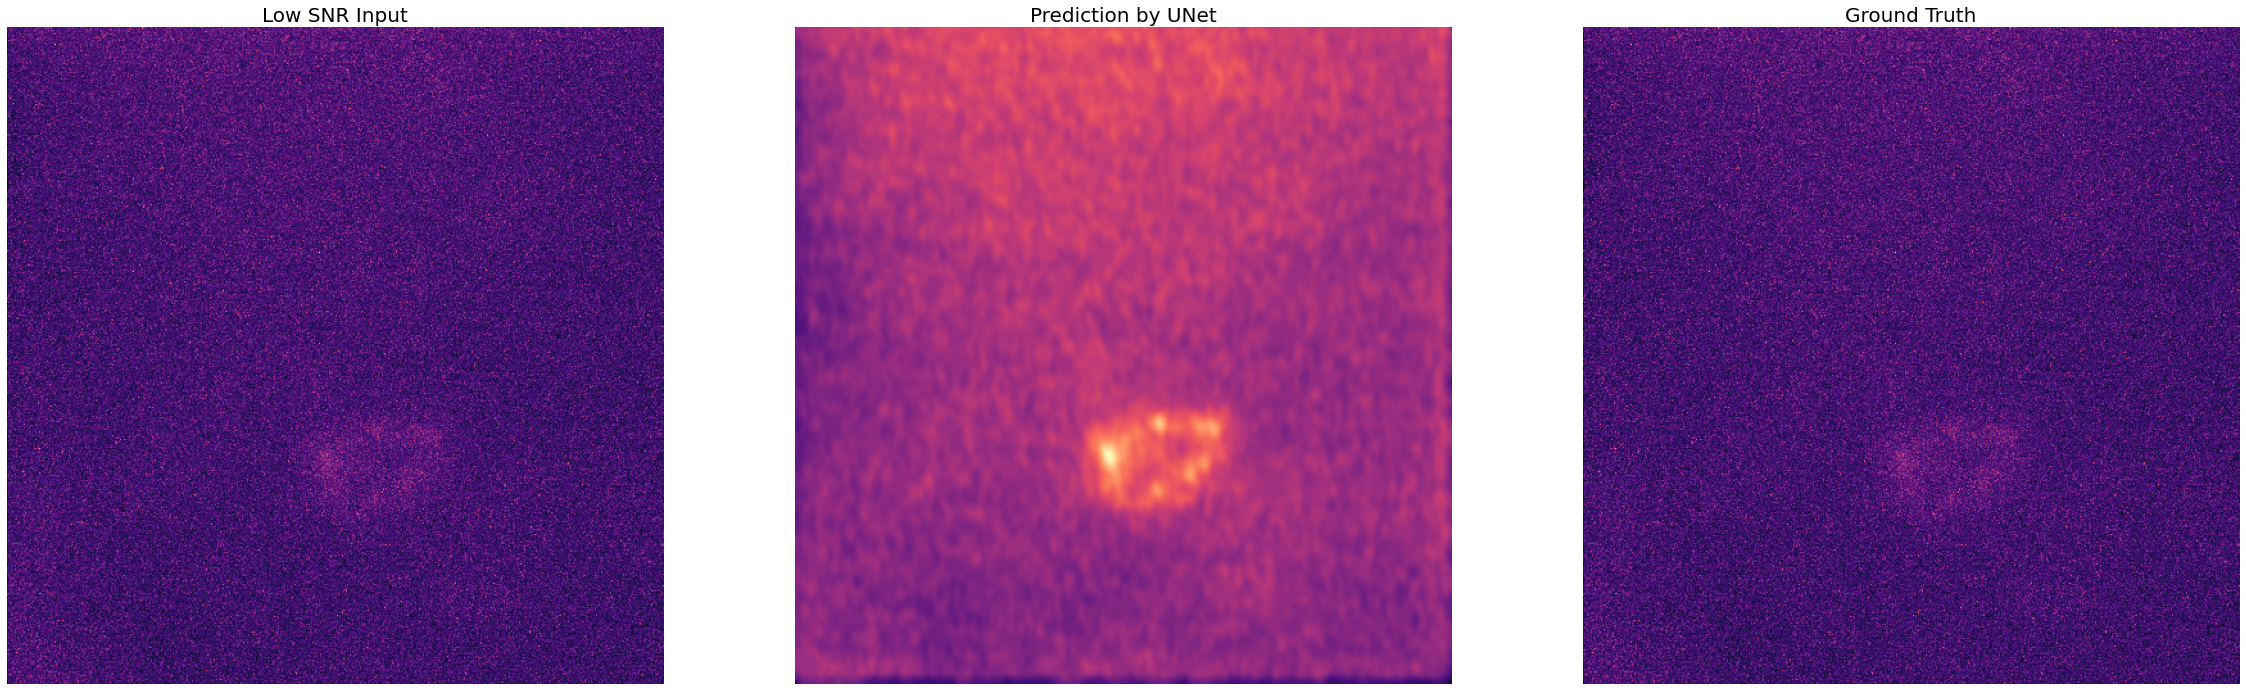

In [79]:
ix = np.random.randint(len(mip_prediction1))
print(ix)
fig = plt.figure(figsize=(40,40))

plt.subplot(1, 3, 1)
plt.imshow(mip_x_test[ix, :, :, 0] , cmap='magma')
plt.title('Low SNR Input',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mip_prediction1[ix, :, :, 0] , cmap='magma')
plt.title('Prediction by UNet',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mip_y_test[ix, :, :, 0] , cmap='magma')
plt.title('Ground Truth',fontdict={'fontsize':20})
plt_axis = plt.axis('off')

In [80]:
save_image_dr = r"C:\Users\va332845\OneDrive - Knights - University of Central Florida\Nanoscopy Group\Experiments\Deep Learning-Fast Wide Field\live cell\DDX39B_photoactivation\a-HCT116_ED_100msAct_G30O200_10s_1" 


from tifffile import imwrite

pred1_test = np.moveaxis(prediction1,3,1)
X_test = np.moveaxis(x_test,3,1)
Y_test = np.moveaxis(y_test,3,1)


pred1_test = pred1_test*(2**16-1)
X_test = X_test*(2**16-1)
Y_test = Y_test*(2**16-1)

pred1_test = pred1_test.astype(np.uint16)
X_test = X_test.astype(np.uint16)
Y_test = Y_test.astype(np.uint16)

imwrite(save_image_dr+'/prediction.tif', pred1_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
imwrite(save_image_dr+'/x_test.tif', X_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})
# imwrite(save_image_dr+'/y_test.tif', Y_test.squeeze(),imagej=True,metadata={'axes': 'TZYX'})

In [ ]:
save_parameters_dr = "/content/drive/MyDrive/WidefieldData/deconvolution/lp50/Parameters50ch1.csv"

def norm_mse(prediction, gt):
    mse = tf.keras.metrics.mean_squared_error(prediction, gt)
    mse = tf.math.reduce_sum(mse, axis=(1, 2))
    norm = tf.norm(gt, axis=(1, 2))
    norm = tf.squeeze(norm)
    norm = tf.pow(norm, 2)
    norm = tf.math.reduce_sum(norm)
    norm_mse = tf.math.divide(mse, norm)
    return norm_mse.numpy()

def nmse_psnr_ssim(prediction,gt):
    nmse = norm_mse(prediction,gt)
    psnr = tf.image.psnr(prediction, gt, max_val = 1.0).numpy()
    ssim = tf.image.ssim_multiscale(prediction.astype(np.float32), gt, max_val = 1.0, filter_size=14,
                                    filter_sigma=1.5, k1=0.01, k2=0.03).numpy()
    return nmse,psnr,ssim
    
imageq_param = np.zeros((6,len(prediction1)))

imageq_param[0::2,:] = nmse_psnr_ssim(mip_x_test,mip_y_test)
imageq_param[1::2,:] = nmse_psnr_ssim(mip_prediction1,mip_y_test)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
labels = ['noisy', 'prediction']

bplot1 = axes[0].boxplot([imageq_param[0,:],imageq_param[1,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[0].set_title('NMSE')

bplot2 = axes[1].boxplot([imageq_param[2,:],imageq_param[3,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
axes[1].set_title('PSNR')

bplot3 = axes[2].boxplot([imageq_param[4,:],imageq_param[5,:]],
                         vert=True,  
                         patch_artist=True,  
                         labels=labels,showfliers=False)  
cc= axes[2].set_title('MS-SSIM')


np.savetxt(save_parameters_dr, np.transpose(imageq_param), delimiter=",")